# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

# Run DASK dist client 

In [2]:

cluster = LocalCluster()
client = Client(cluster)


In [3]:
cluster

LocalCluster(81c15f36, 'tcp://127.0.0.1:35969', workers=5, threads=20, memory=31.03 GiB)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.03 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35969,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.03 GiB
Comm: tcp://127.0.0.1:33985,Total threads: 4
Dashboard: http://127.0.0.1:33255/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:41085,


In [5]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

# Read and merge

In [6]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2020, 2021, 2022, 2023],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [7]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 64.1 ms, sys: 3.44 ms, total: 67.5 ms
Wall time: 65.9 ms


# Preprocessing

In [8]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
# cond = (bbdd_completa['year'].isin([2020]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['year'])
# index+=1
# print(index)
# 4 2019 to 2020 to have continuos data 
# cond = (bbdd_completa['year'].isin([2019]))
# bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
# index+=1
# print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')
# 14138178

(17707721, 23)
1
2
3
4
5
6
(17707721, 21)
Changes to dataframe durinf preprocessing
dropeed 00 rows
dropped -2 columns
CPU times: user 3.62 s, sys: 494 ms, total: 4.11 s
Wall time: 16 s


## Drop not needed data

In [9]:


before = get_ddf_shape(bbdd_completa)
print(before)
# remove data where status is closed
# remove data where status is open but is not returning nor renting
cond = (bbdd_completa['status'].isin([0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['status'])

cond = (bbdd_completa['status'].isin([1])) & (bbdd_completa['is_returning'].isin([0])) & (bbdd_completa['is_renting'].isin([0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')


(17707721, 21)
(17243342, 21)
Changes to dataframe durinf preprocessing
dropeed -464379 rows
dropped 00 columns


## Drop not needed columns 

In [10]:
bbdd_completa = bbdd_completa.drop(
    columns=[
#         'num_docks_available',
#         'timestamp',
#         'num_bikes_available_types.ebike',
#         'num_bikes_available_types.mechanical',
#         'num_bikes_available',
        'is_returning',
        'is_renting',
        'status'
    ]
)

## Drop duplicate data

In [11]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [12]:
def drop_duplicates_per_year(ddf):
    years = ddf.year.unique()
    
    before = get_ddf_shape(ddf)
    print(before)
    
    data = list()
    
    for year in years:
        print(year)
        data_year = ddf[ddf.year.isin([year])]
        
        data_year = data_year.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')
        
        data.append(data_year)
        
        client.run(trim_memory)
        
        time.sleep(1)
        
    ddf_clean = dd.concat(data, interleave_partitions=False)
    
    after = get_ddf_shape(ddf_clean)
    print(after)

    print('Changes to dataframe durinf preprocessing')
    print(f'dropeed {(after[0]-before[0]):02d} rows')
    print(f'dropped {(after[1]-before[1]):02d} columns')
    return ddf_clean


In [13]:
%%time

bbdd_completa = drop_duplicates_per_year(bbdd_completa)

(17243342, 18)
2019
2020
2021
2022
2023
(17104148, 18)
Changes to dataframe durinf preprocessing
dropeed -139194 rows
dropped 00 columns
CPU times: user 10.6 s, sys: 888 ms, total: 11.5 s
Wall time: 41.2 s


# Additional datasets

## Station Information

https://towardsdatascience.com/leveraging-geolocation-data-for-machine-learning-essential-techniques-192ce3a969bc

In [14]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [15]:
df_geo_informacio = pd.read_csv('./dades/station_geoinformacio.csv',sep=',')

In [16]:
df_geo_informacio.drop(['index','Count-2021', 'Count-2022', 'Count-2023', 'Counts'], axis=1, inplace=True)

In [17]:
df_geo_informacio.station_id = df_geo_informacio.station_id.astype(np.int32)

In [18]:
df_geo_informacio.columns


Index(['station_id', 'lon', 'lat'], dtype='object')

In [19]:
df_geo_informacio

,station_id,lon,lat
0,464,2.182335,41.439692
1,115,2.184171,41.383597
2,66,2.167839,41.389322
3,211,2.190212,41.398754
4,52,2.177292,41.381708
...,...,...,...
505,37,2.181903,41.381316
506,126,2.182282,41.380628
507,402,2.182192,41.380628
508,361,2.178810,41.376520


## Festius

In [20]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [21]:
df_calendari_festius = pd.read_csv('./Altres_dades/calendari_festius.csv',sep=';')

In [22]:
df_calendari_festius['fecha'] = pd.to_datetime(df_calendari_festius['fecha'], format='%d/%m/%y')
df_calendari_festius.dtypes

fecha              datetime64[ns]
festius                    object
festius_sun                object
festius_sun_sat            object
dtype: object

In [23]:
df_calendari_festius['year'] = df_calendari_festius['fecha'].dt.year
df_calendari_festius['month'] = df_calendari_festius['fecha'].dt.month
df_calendari_festius['day'] = df_calendari_festius['fecha'].dt.day

In [24]:
df_calendari_festius['dayofweek'] = df_calendari_festius['fecha'].dt.dayofweek

In [25]:
type(df_calendari_festius)

pandas.core.frame.DataFrame

In [26]:
df_calendari_festius.drop('fecha', axis=1, inplace=True)

In [27]:
# replace IN_SERVICE with 0 and CLOSED with 1 
df_calendari_festius['festius'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun_sat'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)


In [28]:
df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([5,6]), 'festius_sun_sat'] = 1
df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([6]), 'festius_sun'] = 1

In [29]:
df_calendari_festius['weekend'] = df_calendari_festius.dayofweek.isin([5,6]).astype(int)

In [30]:
df_calendari_festius[df_calendari_festius.year.isin([2019])].shape

(365, 8)

In [31]:
df_calendari_festius.loc[(df_calendari_festius.festius == 1) & (df_calendari_festius.festius_sun != 1), 'festius'] = 0 

In [32]:
df_calendari_festius.loc[(df_calendari_festius.month == 1) & (df_calendari_festius.day.isin([1,6])), ['festius','festius_sun','festius_sun_sat']] = 1

In [33]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2019])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
0,1,1,1,2019,1,1,1,0
5,1,1,1,2019,1,6,6,1
108,1,1,1,2019,4,19,4,0
111,1,1,1,2019,4,22,0,0
120,1,1,1,2019,5,1,2,0
160,1,1,1,2019,6,10,0,0
174,1,1,1,2019,6,24,0,0
226,1,1,1,2019,8,15,3,0
253,1,1,1,2019,9,11,2,0
266,1,1,1,2019,9,24,1,0


In [34]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2022])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
1096,1,1,1,2022,1,1,5,1
1101,1,1,1,2022,1,6,3,0
1200,1,1,1,2022,4,15,4,0
1203,1,1,1,2022,4,18,0,0
1252,1,1,1,2022,6,6,0,0
1270,1,1,1,2022,6,24,4,0
1322,1,1,1,2022,8,15,0,0
1362,1,1,1,2022,9,24,5,1
1364,1,1,1,2022,9,26,0,0
1380,1,1,1,2022,10,12,2,0


In [35]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2023])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
1461,1,1,1,2023,1,1,6,1
1466,1,1,1,2023,1,6,4,0
1557,1,1,1,2023,4,7,4,0
1560,1,1,1,2023,4,10,0,0


In [36]:
df_calendari_festius.drop('dayofweek', axis=1, inplace=True)

## Meteo

In [37]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [38]:
df_meteo_metadata = pd.read_csv('./Altres_dades/MetadataMeteo/MeteoCat_Metadades.csv',sep=',')

In [39]:
df_meteo_metadata

,CODI_VARIABLE,NOM_VARIABLE,UNITAT,ACRÒNIM
0,1000,Temperatura mitjana diària,°C,TM
1,1001,Temperatura màxima diària + hora,°C,TX
2,1002,Temperatura mínima diària + hora,°C,TN
3,1100,Humitat relativa mitjana diària,%,HRM
4,1101,Humitat relativa màxima diària + data,%,HRX
5,1102,Humitat relativa mínima diària + data,%,HRN
6,1200,Pressió atmosfèrica mitjana diària,hPa,PM
7,1201,Pressió atmosfèrica màxima diària + hora,hPa,PX
8,1202,Pressió atmosfèrica mínima diària + hora,hPa,PN
9,1300,Precipitació acumulada diària,mm,PPT


In [40]:
df_estadistica_meteo_19_d5 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_d5_observatori_fabra.csv',sep=',')
df_estadistica_meteo_19_x2 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x2_barcelona_zoo.csv',sep=',')
df_estadistica_meteo_19_x4 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x4_barcelona_el_raval.csv',sep=',')
df_estadistica_meteo_19_x8 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x8_barcelona_zona_universitaria.csv',sep=',')

In [41]:
def convert_columns(data):
    print(data.shape)
    
    data.rename(
        columns={
            'PPT24H':'PPT',
            'DVX10':'DVVX10',
            'RS24H':'RS24h',
            'HPA':'PM'
        },
        inplace=True
    )
    
    for acro in df_meteo_metadata['ACRÒNIM'].values:
        if acro not in data.columns.values:
            data[acro] = np.nan
    
    code = data.CODI_ESTACIO.unique().tolist().pop()
    
    data.drop('CODI_ESTACIO', axis=1, inplace=True)

    data = data.set_index('DATA_LECTURA')

    data.columns = [f'VALOR_{col}_{code}' for col in data.columns.values]

    data = data.reset_index()

    data['DATA_LECTURA'] = pd.to_datetime(data['DATA_LECTURA'], format='%d/%m/%Y')
#     data['year'] = data['DATA_LECTURA'].dt.year
    
    print(data.shape)
    
    return data

In [42]:
df_estadistica_meteo_19_d5 = convert_columns(df_estadistica_meteo_19_d5)

df_estadistica_meteo_19_x2 = convert_columns(df_estadistica_meteo_19_x2)

df_estadistica_meteo_19_x4 = convert_columns(df_estadistica_meteo_19_x4)

df_estadistica_meteo_19_x8 = convert_columns(df_estadistica_meteo_19_x8)

(8766, 13)
(8766, 16)
(4832, 6)
(4832, 16)
(4809, 13)
(4809, 16)
(4262, 13)
(4262, 16)


In [43]:
df_estadistica_meteo_19 = pd.merge(
    pd.merge(
        df_estadistica_meteo_19_d5, df_estadistica_meteo_19_x2, 
        on='DATA_LECTURA',
        how='outer',
    ),
    pd.merge(
        df_estadistica_meteo_19_x4, df_estadistica_meteo_19_x8, 
        on='DATA_LECTURA',
        how='outer',
    ), 
    on='DATA_LECTURA',
    how='outer',
)


In [44]:
df_estadistica_meteo_19['year'] = df_estadistica_meteo_19['DATA_LECTURA'].dt.year

df_estadistica_meteo_19 = df_estadistica_meteo_19[df_estadistica_meteo_19.year.isin([2019])]

In [45]:
df_estadistica_meteo_20 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2020_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_21 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2021_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_22 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2022_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_23 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2023_MeteoCat_Detall_Estacions.csv',sep=',')


In [46]:
%%time 

df_estadistica_meteo_20.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_20.shape)

df_estadistica_meteo_21.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_21.shape)

df_estadistica_meteo_22.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_22.shape)

df_estadistica_meteo_23.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_23.shape)

df_20_21_22_23 = pd.concat([df_estadistica_meteo_20, df_estadistica_meteo_21, df_estadistica_meteo_22, df_estadistica_meteo_23])
print(df_20_21_22_23.shape)
#change indexing 
df_20_21_22_23 = pd.DataFrame(df_20_21_22_23.set_index(['ACRÒNIM', 'DATA_LECTURA', 'CODI_ESTACIO']).unstack(['ACRÒNIM']))
df_20_21_22_23 = df_20_21_22_23.reindex()
df_20_21_22_23 = df_20_21_22_23.unstack()
df_20_21_22_23.columns = ['_'.join(col) for col in df_20_21_22_23.columns.values]
df_20_21_22_23 = df_20_21_22_23.reset_index()

df_20_21_22_23['DATA_LECTURA'] = pd.to_datetime(df_20_21_22_23['DATA_LECTURA'], format='%Y-%m-%d')
df_20_21_22_23['year'] = df_20_21_22_23['DATA_LECTURA'].dt.year

# checking duplicates 
print('is there duplicates: ', (df_20_21_22_23.groupby('DATA_LECTURA').count().reset_index().VALOR_DVM10_D5 > 1 ).any())

print(df_20_21_22_23.shape)

(18637, 4)
(18615, 4)
(18605, 4)
(8007, 4)
(63864, 4)
is there duplicates:  False
(1253, 62)
CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 29.2 ms


In [47]:
df_estadistica_meteo = pd.concat([df_estadistica_meteo_19, df_20_21_22_23])

In [48]:
df_estadistica_meteo

,DATA_LECTURA,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_PM_X2,VALOR_PX_X2,VALOR_PN_X2,VALOR_PPT_X2,VALOR_RS24h_X2,VALOR_VVM10_X2,VALOR_DVM10_X2,VALOR_VVX10_X2,VALOR_DVVX10_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,year
8401,2019-01-01,10.5,14.4,7.8,73.0,0.0,979.6,5.4,3.8,339.0,15.8,315.0,NaN,NaN,NaN,NaN,9.9,15.4,4.9,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,16.0,8.4,66.0,0.0,1024.5,8.2,1.3,307.0,7.9,301.0,NaN,NaN,NaN,NaN,11.2,17.0,7.0,71.0,0.0,1019.0,7.4,1.4,311.0,9.0,303.0,NaN,NaN,NaN,NaN,2019
8402,2019-01-02,8.9,12.9,5.9,48.0,0.0,976.5,9.4,8.3,324.0,17.3,318.0,NaN,NaN,NaN,NaN,8.8,14.5,5.1,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.2,16.3,8.1,47.0,0.0,1021.4,9.2,1.0,280.0,6.3,309.0,NaN,NaN,NaN,NaN,9.5,15.3,5.7,52.0,0.0,1015.9,9.1,1.7,293.0,10.2,304.0,NaN,NaN,NaN,NaN,2019
8403,2019-01-03,8.3,12.6,4.9,59.0,0.0,979.0,9.1,4.0,279.0,9.9,313.0,NaN,NaN,NaN,NaN,7.6,13.0,4.1,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,13.7,7.5,53.0,0.0,1024.3,8.9,1.1,264.0,4.6,263.0,NaN,NaN,NaN,NaN,8.8,13.4,4.4,59.0,0.0,1018.7,8.8,1.3,277.0,6.0,306.0,NaN,NaN,NaN,NaN,2019
8404,2019-01-04,7.2,11.3,5.3,69.0,0.0,980.6,8.0,2.0,205.0,7.8,290.0,NaN,NaN,NaN,NaN,7.0,11.7,3.3,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,12.3,6.4,59.0,0.0,1026.1,7.9,0.9,94.0,4.8,80.0,NaN,NaN,NaN,NaN,7.0,12.6,2.6,70.0,0.0,1020.5,7.7,1.2,292.0,4.1,164.0,NaN,NaN,NaN,NaN,2019
8405,2019-01-05,9.1,15.2,3.2,47.0,0.0,978.6,9.3,10.0,326.0,17.0,317.0,NaN,NaN,NaN,NaN,8.5,15.3,4.4,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9,16.3,6.8,45.0,0.0,1023.6,9.2,2.0,282.0,7.5,267.0,NaN,NaN,NaN,NaN,9.4,14.1,5.4,50.0,0.0,1018.1,9.2,3.1,296.0,10.8,307.0,NaN,NaN,NaN,NaN,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2023-06-02,18.9,24.7,15.4,80.0,0.0,966.5,24.3,2.0,202.0,7.1,157.0,100.0,56.0,967.5,965.2,20.1,24.1,16.9,79.0,93.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,23.2,18.2,74.0,0.0,1010.0,24.9,1.7,159.0,5.9,152.0,92.0,55.0,1011.0,1008.6,20.6,25.2,15.8,77.0,0.0,1004.4,23.5,1.5,207.0,6.1,174.0,99.0,54.0,1005.4,1003.0,2023
1249,2023-06-03,18.2,22.8,15.3,86.0,0.1,966.9,15.4,1.8,190.0,6.9,151.0,100.0,65.0,968.0,965.4,20.3,22.7,17.6,81.0,91.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,22.8,18.9,76.0,0.0,1010.5,18.2,1.6,149.0,6.6,174.0,91.0,59.0,1011.7,1009.0,20.5,25.3,16.9,78.0,0.0,1004.8,16.2,1.4,170.0,6.9,181.0,100.0,58.0,1006.1,1003.4,2023
1250,2023-06-04,19.1,25.7,16.2,82.0,0.0,967.8,21.6,1.8,184.0,7.0,167.0,100.0,51.0,969.0,966.6,20.5,24.5,17.9,81.0,91.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,23.9,18.9,76.0,0.0,1011.4,23.8,1.6,127.0,6.3,101.0,93.0,62.0,1012.6,1010.2,20.8,25.9,17.2,77.0,0.0,1005.7,22.5,1.4,176.0,6.3,132.0,99.0,51.0,1007.0,1004.6,2023
1251,2023-06-05,19.9,25.5,15.9,75.0,0.0,968.0,26.1,3.3,239.0,8.9,191.0,99.0,52.0,968.8,966.9,21.5,25.7,17.3,75.0,91.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,24.6,18.9,67.0,0.0,1011.5,28.6,1.8,193.0,7.7,155.0,80.0,56.0,1012.4,1010.0,21.8,26.5,16.7,70.0,0.0,1005.9,27.7,1.7,220.0,7.2,209.0,95.0,51.0,1006.8,1004.7,2023


In [49]:
df_estadistica_meteo['month'] = df_estadistica_meteo['DATA_LECTURA'].dt.month
df_estadistica_meteo['day'] = df_estadistica_meteo['DATA_LECTURA'].dt.day

In [50]:
df_estadistica_meteo.drop('DATA_LECTURA', axis=1, inplace=True)

In [51]:
%%time

nans = get_features_nans(df_estadistica_meteo)

zeros = get_features_zero(df_estadistica_meteo)

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 10.3 ms


In [52]:
nans

{'VALOR_TM_D5': 0.061804697156983925,
 'VALOR_HRM_D5': 0.061804697156983925,
 'VALOR_RS24h_D5': 0.4326328800988875,
 'VALOR_VVM10_D5': 0.3708281829419036,
 'VALOR_DVM10_D5': 0.6180469715698393,
 'VALOR_VVX10_D5': 0.4326328800988875,
 'VALOR_DVVX10_D5': 0.30902348578491967,
 'VALOR_HRX_D5': 22.558714462299136,
 'VALOR_HRN_D5': 22.558714462299136,
 'VALOR_PX_D5': 22.558714462299136,
 'VALOR_PN_D5': 22.558714462299136,
 'VALOR_HRX_X2': 22.558714462299136,
 'VALOR_HRN_X2': 22.558714462299136,
 'VALOR_PM_X2': 100.0,
 'VALOR_PX_X2': 100.0,
 'VALOR_PN_X2': 100.0,
 'VALOR_PPT_X2': 100.0,
 'VALOR_RS24h_X2': 100.0,
 'VALOR_VVM10_X2': 100.0,
 'VALOR_DVM10_X2': 100.0,
 'VALOR_VVX10_X2': 100.0,
 'VALOR_DVVX10_X2': 100.0,
 'VALOR_VVM10_X4': 0.061804697156983925,
 'VALOR_DVM10_X4': 0.061804697156983925,
 'VALOR_HRX_X4': 22.558714462299136,
 'VALOR_HRN_X4': 22.558714462299136,
 'VALOR_PX_X4': 22.558714462299136,
 'VALOR_PN_X4': 22.558714462299136,
 'VALOR_HRX_X8': 22.558714462299136,
 'VALOR_HRN_X8': 

In [53]:
zeros

{'VALOR_PPT_D5': 77.07045735475896,
 'VALOR_DVM10_D5': 0.12360939431396785,
 'VALOR_DVVX10_D5': 0.30902348578491967,
 'VALOR_PPT_X4': 79.41903584672436,
 'VALOR_DVM10_X4': 0.061804697156983925,
 'VALOR_PPT_X8': 77.99752781211372}

In [54]:
nans = pd.Series(nans)

nancolumns = nans[nans >= 90].index.values
nancolumns

array(['VALOR_PM_X2', 'VALOR_PX_X2', 'VALOR_PN_X2', 'VALOR_PPT_X2',
       'VALOR_RS24h_X2', 'VALOR_VVM10_X2', 'VALOR_DVM10_X2',
       'VALOR_VVX10_X2', 'VALOR_DVVX10_X2'], dtype=object)

In [55]:
df_estadistica_meteo.drop(columns=nancolumns,axis=1, inplace=True)

In [56]:
df_estadistica_meteo.columns

Index(['VALOR_TM_D5', 'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5',
       'VALOR_PPT_D5', 'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5',
       'VALOR_DVM10_D5', 'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5',
       'VALOR_HRN_D5', 'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2',
       'VALOR_TX_X2', 'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2',
       'VALOR_HRN_X2', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4',
       'VALOR_HRM_X4', 'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4',
       'VALOR_VVM10_X4', 'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4',
       'VALOR_HRX_X4', 'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4',
       'VALOR_TM_X8', 'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8',
       'VALOR_PPT_X8', 'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8',
       'VALOR_DVM10_X8', 'VALOR_VVX10_X8', 'VALOR_DVVX10_X8', 'VALOR_HRX_X8',
       'VALOR_HRN_X8', 'VALOR_PX_X8', 'VALOR_PN_X8', 'year', 'month', 'day'],
      dtype='object')

In [57]:
columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4', 'year', 'month', 'day']

In [58]:
df_estadistica_meteo = df_estadistica_meteo.loc[:, columns_meteo]

In [59]:
df_estadistica_meteo.columns

Index(['VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4', 'year',
       'month', 'day'],
      dtype='object')

# Split estaciones 2019 - 2022

## Part 1 

Split by station existance from 2019 until 2022

In [60]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [61]:
%%time

bbdd_completa_19_22 = bbdd_completa[bbdd_completa.year.isin([2019, 2020, 2021, 2022])]

CPU times: user 2.16 ms, sys: 381 µs, total: 2.54 ms
Wall time: 2.45 ms


In [62]:
%%time

unique_ids_by_year = bbdd_completa_19_22.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

year
2019    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2020    [1, 301, 300, 299, 14, 298, 297, 296, 295, 294...
2021    [1, 271, 400, 510, 26, 270, 269, 401, 268, 267...
2022    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
CPU times: user 2.97 s, sys: 263 ms, total: 3.24 s
Wall time: 15.1 s


In [63]:
# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print('total:',len(common_ids))

2019 (410,)
2020 (508,)
2021 (509,)
2022 (510,)
total: 408


In [64]:
filtered_bbdd = bbdd_completa_19_22[bbdd_completa_19_22['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa_19_22[~bbdd_completa_19_22['station_id'].isin(common_ids)]

In [65]:
bbdd_completa_19_22 = None

# Convert to Pandas 

In [66]:
%%time 

X_train = filtered_bbdd.compute().copy()

CPU times: user 4.77 s, sys: 3.2 s, total: 7.98 s
Wall time: 20.1 s


In [67]:
%%time 

X_val = nonfiltered_bbdd.compute().copy()

CPU times: user 3.26 s, sys: 799 ms, total: 4.06 s
Wall time: 15.9 s


In [68]:
%%time

X_test = bbdd_completa[bbdd_completa.year.isin([2023])].compute().copy()

CPU times: user 3.12 s, sys: 640 ms, total: 3.76 s
Wall time: 14.8 s


## Shutdown DASK dist client

In [69]:
client.run(trim_memory)

{'tcp://127.0.0.1:33793': 1,
 'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:34091': 1,
 'tcp://127.0.0.1:41537': 1,
 'tcp://127.0.0.1:46321': 1}

In [70]:
client.shutdown()

# Merge additional data

### Merge with data geo

In [71]:

X_train = pd.merge(X_train, df_geo_informacio, on=['station_id'], how='left')
X_val = pd.merge(X_val, df_geo_informacio, on=['station_id'], how='left')
X_test = pd.merge(X_test, df_geo_informacio, on=['station_id'], how='left')


### Merge with data festius

In [72]:

X_train = pd.merge(X_train, df_calendari_festius, on=['year', 'month', 'day'], how='left')
X_val = pd.merge(X_val, df_calendari_festius, on=['year', 'month', 'day'], how='left')
X_test = pd.merge(X_test, df_calendari_festius, on=['year', 'month', 'day'], how='left')


### Merge with data meteo

In [73]:

X_train = pd.merge(X_train, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')
X_val = pd.merge(X_val, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')
X_test = pd.merge(X_test, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')


# Final Cleaning & preprocessing

In [75]:
X_train.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'timestamp',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
       'lon', 'lat', 'festius', 'festius_sun', 'festius_sun_sat', 'weekend',
       'VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4'],
      dtype='object')

In [76]:
X_test.festius.fillna(0, inplace=True)
X_test.festius_sun.fillna(0, inplace=True)
X_test.festius_sun_sat.fillna(0, inplace=True)
X_test.weekend.fillna(0, inplace=True)

X_test.loc[X_test.dayofweek.isin([5,6]),'weekend'] = 1
X_test.loc[X_test.dayofweek.isin([5,6]),'festius_sun_sat'] = 1
X_test.loc[X_test.dayofweek.isin([6]),'festius_sun'] = 1


In [77]:
%%time

nans = get_features_nans(X_test)

zeros = get_features_zero(X_test)

CPU times: user 1.53 s, sys: 45 ms, total: 1.57 s
Wall time: 1.56 s


In [78]:
nans

{'lon': 0.025519758318436964, 'lat': 0.025519758318436964}

In [79]:
zeros

{'num_docks_available': 0.5337292046460137,
 'num_bikes_available': 1.5606041093899714,
 'num_bikes_available_types.mechanical': 15.803228485721341,
 'num_bikes_available_types.ebike': 11.221191323754761,
 'dayofweek': 14.184909552541756,
 'hour': 4.079912287645484,
 'ctx0': 0.5337292046460137,
 'ctx1': 0.5338473516752658,
 'ctx2': 0.5359739982018022,
 'ctx3': 0.5386323063599727,
 'ctx4': 0.540640805857257,
 'festius': 98.01229437986396,
 'festius_sun': 86.1954057346205,
 'festius_sun_sat': 61.13931543248311,
 'weekend': 74.54339126869824,
 'VALOR_PPT_X4': 77.99334359637194}

In [80]:
%%time

nans = get_features_nans(pd.concat([X_train, X_val, X_test]))

zeros = get_features_zero(pd.concat([X_train, X_val, X_test]))

CPU times: user 16.5 s, sys: 2.1 s, total: 18.6 s
Wall time: 18.5 s


In [81]:
nans

{'lon': 0.1315938098758266, 'lat': 0.1315938098758266}

In [82]:
zeros

{'num_docks_available': 1.012900496417594,
 'num_bikes_available': 3.302339292199764,
 'num_bikes_available_types.mechanical': 13.076371883592214,
 'num_bikes_available_types.ebike': 27.448090369657702,
 'dayofweek': 14.281740312349964,
 'hour': 4.139720961254545,
 'ctx0': 1.012900496417594,
 'ctx1': 1.0131051251427432,
 'ctx2': 1.0145141400787692,
 'ctx3': 1.0162681005800465,
 'ctx4': 1.0171158481556637,
 'festius': 96.17766403798657,
 'festius_sun': 82.25607612843388,
 'festius_sun_sat': 54.95135449015057,
 'weekend': 71.80626594203933,
 'VALOR_PPT_X4': 79.53867097034006}

## Feature extraction

In [84]:
columns = ['ctx1', 'ctx2', 'ctx3', 'ctx4']
combination = [columns[:i] for i in range(2,len(columns)+1)]

for comb in combination:
    suffix = '_'.join(comb)
    print(suffix)
    X_train[f'{suffix}_mean'] = X_train[comb].mean(axis=1)
    X_train[f'{suffix}_std'] = X_train[comb].std(axis=1)
    
    X_val[f'{suffix}_mean'] = X_val[comb].mean(axis=1)
    X_val[f'{suffix}_std'] = X_val[comb].std(axis=1)
    
    X_test[f'{suffix}_mean'] = X_test[comb].mean(axis=1)
    X_test[f'{suffix}_std'] = X_test[comb].std(axis=1)
    

ctx1_ctx2
ctx1_ctx2_ctx3
ctx1_ctx2_ctx3_ctx4


# Save prepared data to a file 

In [85]:
%%time

X_train.to_csv('dades/processed/training_data.csv', header=True, index=True, index_label='index')

CPU times: user 3min 36s, sys: 3.02 s, total: 3min 39s
Wall time: 3min 38s


In [86]:
%%time 

X_val.to_csv('dades/processed/validation_data.csv', header=True, index=True, index_label='index')

CPU times: user 35.7 s, sys: 620 ms, total: 36.3 s
Wall time: 36.3 s


In [87]:
%%time 

X_test.to_csv('dades/processed/testing_data.csv', header=True, index=True, index_label='index')

CPU times: user 28.9 s, sys: 540 ms, total: 29.4 s
Wall time: 29.6 s


In [95]:
y_train = X_train.ctx0.copy()
y_val = X_val.ctx0.copy()
y_test = X_test.ctx0.copy()

# View

In [177]:
years = X_train.year.unique().tolist()
years

[2019, 2020, 2021, 2022]

In [178]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Run pipeline

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [160]:
X_train.columns, X_train.columns.shape

(Index(['station_id', 'num_docks_available', 'num_bikes_available', 'timestamp',
        'num_bikes_available_types.mechanical',
        'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
        'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
        'lon', 'lat', 'festius', 'festius_sun', 'festius_sun_sat', 'weekend',
        'VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4',
        'ctx1_ctx2_mean', 'ctx1_ctx2_std', 'ctx1_ctx2_ctx3_mean',
        'ctx1_ctx2_ctx3_std', 'ctx1_ctx2_ctx3_ctx4_mean',
        'ctx1_ctx2_ctx3_ctx4_std'],
       dtype='object'),
 (34,))

In [167]:
%%time 

columns = X_train.columns#[['VALOR' not in i for i in X_train.columns]].to_list()

correlations = np.abs(
    X_train[columns].corr(method='pearson').ctx0
).sort_values(ascending=False)

correlations.to_dict()

CPU times: user 27.1 s, sys: 3.13 s, total: 30.3 s
Wall time: 30.3 s


{'ctx0': 1.0,
 'ctx1': 0.9129730514796786,
 'num_docks_available': 0.9055683555185408,
 'num_bikes_available': 0.8893401764262853,
 'ctx1_ctx2_mean': 0.8749838959980546,
 'num_bikes_available_types.mechanical': 0.8419660611344777,
 'ctx1_ctx2_ctx3_mean': 0.8385814221879833,
 'ctx1_ctx2_ctx3_ctx4_mean': 0.8038040173697455,
 'ctx2': 0.798489435958584,
 'ctx3': 0.6970754741833134,
 'ctx4': 0.6062960341913912,
 'lon': 0.263030547218921,
 'num_bikes_available_types.ebike': 0.2176339648798674,
 'ctx1_ctx2_ctx3_ctx4_std': 0.12158394131660641,
 'ctx1_ctx2_ctx3_std': 0.1095952719694649,
 'ctx1_ctx2_std': 0.09072430957769924,
 'lat': 0.07074776190628096,
 'station_id': 0.06967142131249375,
 'timestamp': 0.061366489615208346,
 'year': 0.051252756351171845,
 'dayofyear': 0.04284937914584141,
 'month': 0.042743878873176405,
 'hour': 0.02565808047205957,
 'weekend': 0.019847936776268647,
 'VALOR_TM_X4': 0.018843062466437126,
 'VALOR_TN_X4': 0.0183309405258427,
 'VALOR_TX_X4': 0.017481569929004268,
 

In [168]:
columns_ctx = X_train.columns[['ctx' in i for i in X_train.columns]].to_list()
columns_ctx.remove('ctx0')
print(len(columns_ctx))

columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']
print(len(columns_meteo))

columns_time = ['month', 'dayofyear', 'hour', 'dayofweek', 'day'] 
print(len(columns_time))

columns_location = ['lon', 'lat']
print(len(columns_location))

columns_festius = ['festius_sun', 'weekend']
print(len(columns_festius))


10
4
5
2
2


In [169]:
class Config:
    num_attribs0 = ['capacity'] + columns_ctx + columns_meteo
    cat_attribs0 = columns_time
    cat_attribs1 = ['']
    gen_attribs0 = ['station_id'] + columns_festius + columns_location
    target_col = ['ctx0']
    
    seed=42
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [170]:
config=Config()
seed_everything(config.seed)

In [171]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
#             ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [172]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 190 µs, sys: 27 µs, total: 217 µs
Wall time: 2.06 ms


In [173]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'ctx1_ctx2_mean', 'ctx1_ctx2_std',
                                  'ctx1_ctx2_ctx3_mean', 'ctx1_ctx2_ctx3_std',
                                  'ctx1_ctx2_ctx3_ctx4_mean',
                                  'ctx1_ctx2_ctx3_ctx4_std', 'VALOR_TN_X4',
                                  'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('ge...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['station_id', 'festius_sun', 'weekend', 'lon',
                                  'lat']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['month', 'dayofyear', 'hour', 'dayofweek',
                                  'day'])])

In [174]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [179]:
[months.remove(x) for x in [6,7,8,9,10]]

[None, None, None, None, None]

In [185]:
years, months

([2019, 2020, 2021, 2022], [1, 2, 3, 4, 5, 11, 12])

In [186]:
X_train.shape,y_train.shape

((13143819, 34), (13143819,))

In [187]:
X_val.shape, y_val.shape

((2267523, 34), (2267523,))

In [188]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2021, 2022], months, True)


train
X (4108638, 34) X_prepared: (4108638, 25) y:  (4108638,)
val
X (1016614, 34) X_prepared: (1016614, 25) y:  (1016614,)
test
X (358887, 34) X_prepared: (358887, 25) y:  (358887,)


In [189]:
import gc

gc.collect()

48

# Prediction

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [190]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [191]:
lin_reg = LinearRegression(n_jobs=5)

In [192]:
ridge_reg = Ridge(alpha=.3, random_state=config.seed)

In [193]:
lasso_reg = Lasso(alpha=0.01, random_state=config.seed)

In [194]:
elasticNet_reg = ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=config.seed) 

### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   13.6s remaining:   20.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   13.8s finished



  model test
Scores: [-0.11166467 -0.11151427 -0.11362    -0.11551702 -0.11574956]
Mean: -0.113613101078695
Standard deviation: 0.0018105739648623788

Training time: 0.099 s
----- EVALUATION ON VAL SET ------
MSE: 0.012904998323003678
RMSE 0.11360016867506702
MAE: 0.07454470635792958
R^2:  0.823742318956561



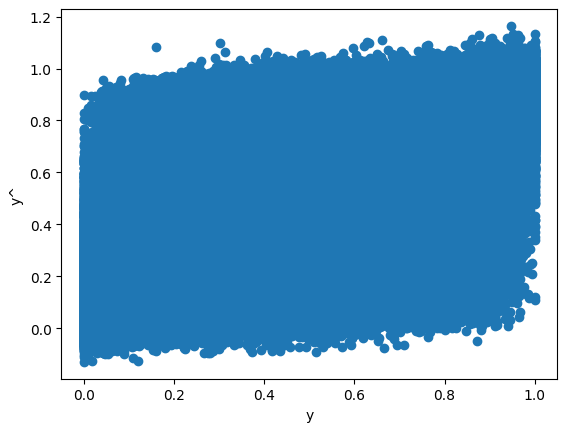


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941914916008768
RMSE 0.09456169899070536
MAE: 0.059392345651216094
R^2:  0.8710450641222052



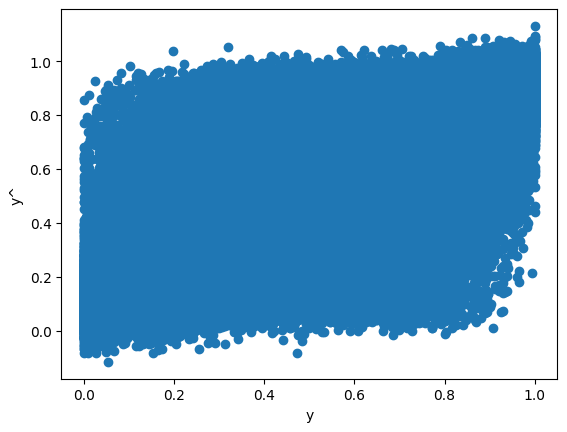


Testing time: 0.01 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933427355911548
RMSE 0.11803993966413041
MAE: 0.07891786160971462
R^2:  0.8094868093025294



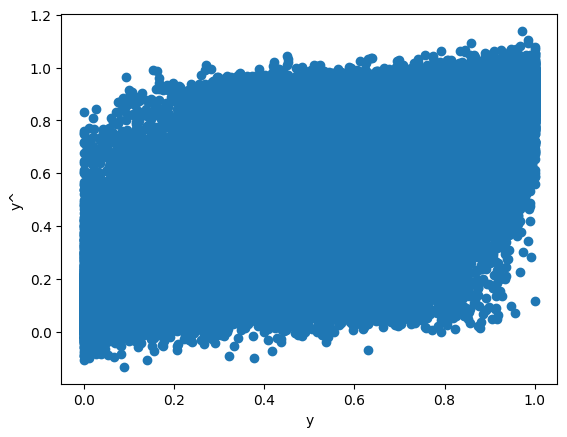

CPU times: user 20.7 s, sys: 20.6 s, total: 41.3 s
Wall time: 26.2 s


{'train': mse_t     0.012905
 rmse_t      0.1136
 mae_t     0.074545
 r2_t      0.823742
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059392
 r2_t      0.871045
 mse_v     0.013933
 rmse_v     0.11804
 mae_v     0.078918
 r2_v      0.809487
 dtype: object}

In [195]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished



  model test
Scores: [-0.11558634 -0.11541634 -0.11693974 -0.11855586 -0.11879798]
Mean: -0.11705925267850711
Standard deviation: 0.0014244941427146668

Training time: 0.1 s
----- EVALUATION ON VAL SET ------
MSE: 0.013699732716607986
RMSE 0.11704585732356351
MAE: 0.07924787345385471
R^2:  0.8128877618496093



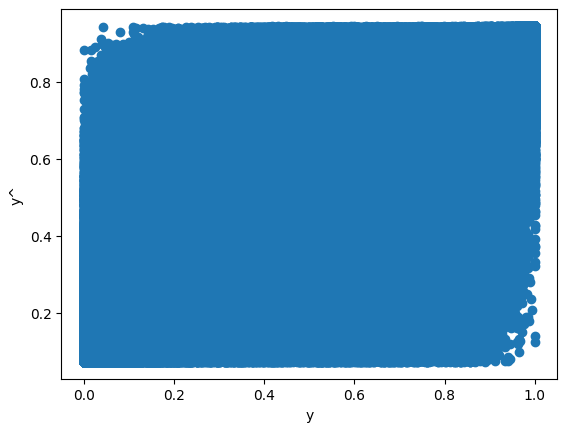


Training time: 0.024 s
----- EVALUATION ON VAL SET ------
MSE: 0.009821850766853117
RMSE 0.09910525095499792
MAE: 0.06555531868412684
R^2:  0.8583551568385811



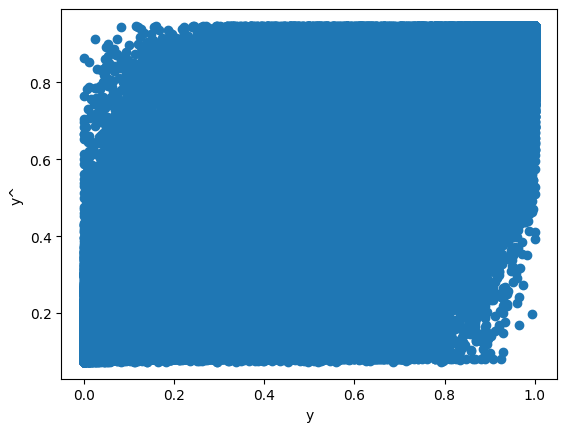


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.01472961113720383
RMSE 0.121365609367744
MAE: 0.08339452832727937
R^2:  0.7986005062644462



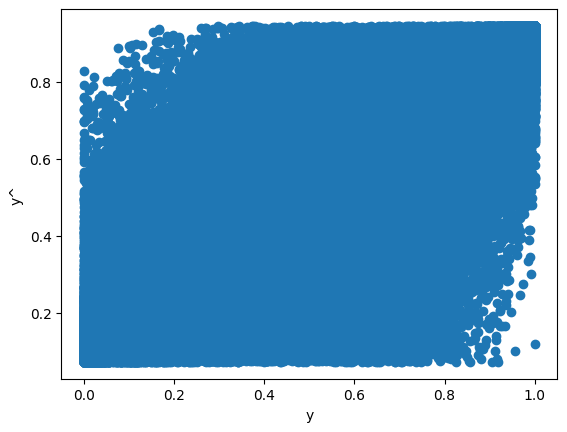

CPU times: user 13.9 s, sys: 6.77 s, total: 20.6 s
Wall time: 13.6 s


{'train': mse_t       0.0137
 rmse_t    0.117046
 mae_t     0.079248
 r2_t      0.812888
 dtype: object,
 'test': mse_t     0.009822
 rmse_t    0.099105
 mae_t     0.065555
 r2_t      0.858355
 mse_v      0.01473
 rmse_v    0.121366
 mae_v     0.083395
 r2_v      0.798601
 dtype: object}

In [196]:
%%time 

test_model_train_val_test(
    lasso_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished



  model test
Scores: [-0.11166477 -0.11151436 -0.11361998 -0.11551692 -0.11574948]
Mean: -0.11361309891748687
Standard deviation: 0.0018104911285674718

Training time: 0.1 s
----- EVALUATION ON VAL SET ------
MSE: 0.012904998334101006
RMSE 0.11360016872391082
MAE: 0.07454458386787252
R^2:  0.8237423188049926



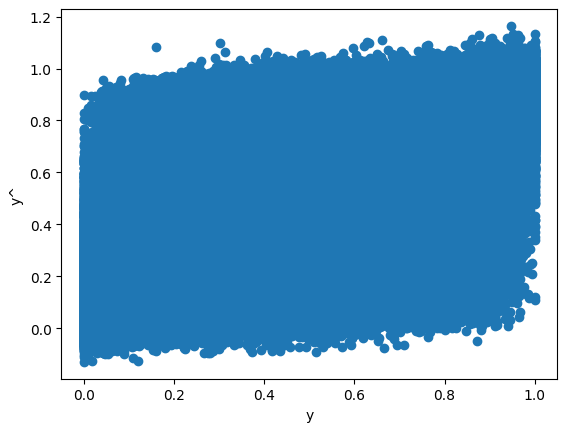


Training time: 0.024 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941933471224435
RMSE 0.09456179710234168
MAE: 0.05939265300509684
R^2:  0.8710447965300094



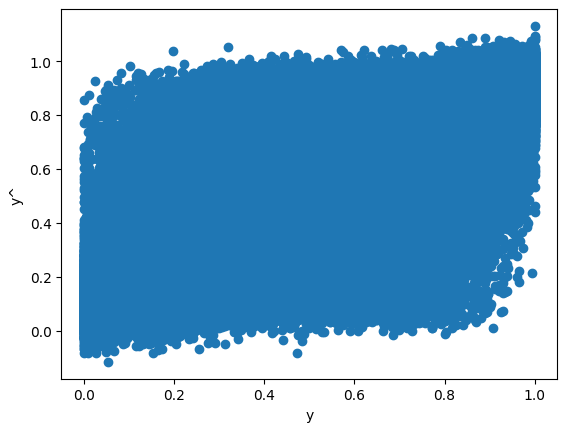


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933424598199733
RMSE 0.11803992798286406
MAE: 0.07891771636009996
R^2:  0.8094868470090077



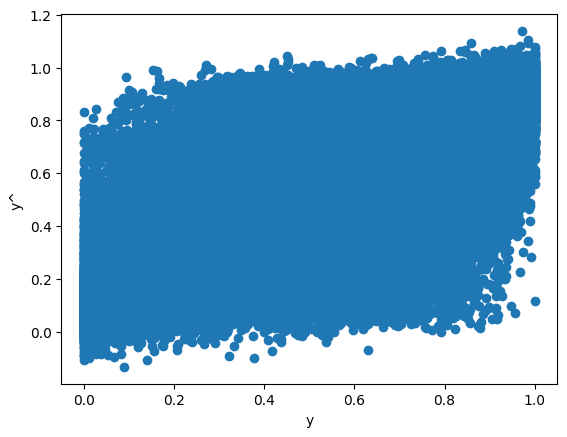

CPU times: user 10.9 s, sys: 5.09 s, total: 16 s
Wall time: 10.4 s


{'train': mse_t     0.012905
 rmse_t      0.1136
 mae_t     0.074545
 r2_t      0.823742
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059393
 r2_t      0.871045
 mse_v     0.013933
 rmse_v     0.11804
 mae_v     0.078918
 r2_v      0.809487
 dtype: object}

In [197]:
%%time 

test_model_train_val_test(
    ridge_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.4s finished



  model test
Scores: [-0.11402518 -0.11387279 -0.11560933 -0.1173843  -0.11764193]
Mean: -0.11570670602735504
Standard deviation: 0.0015974769697069307

Training time: 0.104 s
----- EVALUATION ON VAL SET ------
MSE: 0.013384990745667447
RMSE 0.1156935207592346
MAE: 0.07683718048833174
R^2:  0.8171865372958744



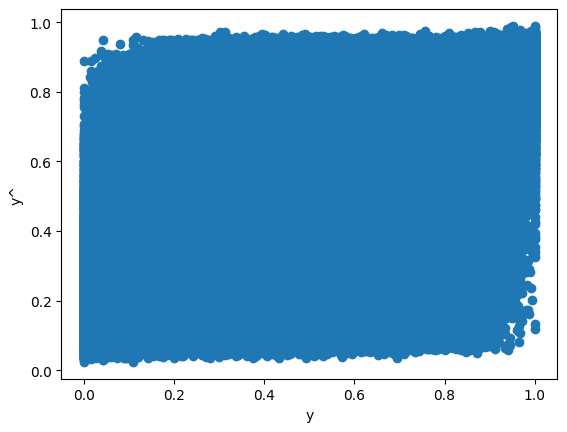


Training time: 0.024 s
----- EVALUATION ON VAL SET ------
MSE: 0.009485369965622398
RMSE 0.09739286403850335
MAE: 0.06284686141119913
R^2:  0.8632076812200348



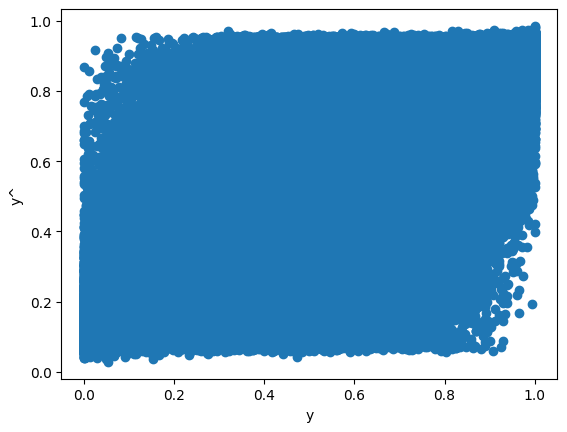


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014418843773090384
RMSE 0.12007849005167572
MAE: 0.08114910192830199
R^2:  0.802849660516991



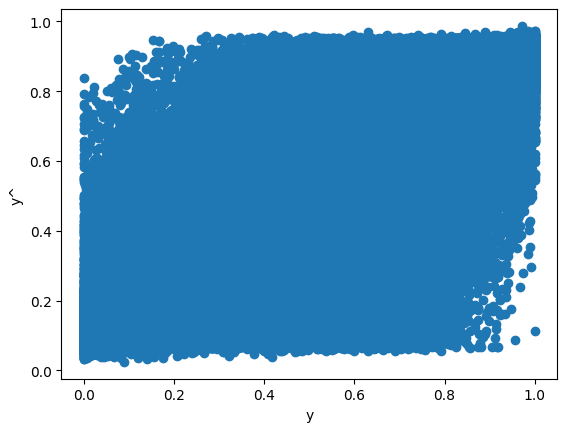

CPU times: user 37.3 s, sys: 10.1 s, total: 47.4 s
Wall time: 21 s


{'train': mse_t     0.013385
 rmse_t    0.115694
 mae_t     0.076837
 r2_t      0.817187
 dtype: object,
 'test': mse_t     0.009485
 rmse_t    0.097393
 mae_t     0.062847
 r2_t      0.863208
 mse_v     0.014419
 rmse_v    0.120078
 mae_v     0.081149
 r2_v       0.80285
 dtype: object}

In [198]:
%%time 

test_model_train_val_test(
    elasticNet_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


# Generate Sample

In [199]:
sample_data = pd.read_csv('dades/metadata_sample_submission.csv/metadata_sample_submission.csv')

In [200]:
sample_data['year'] = 2023

In [201]:
sample_data['datetime'] = pd.to_datetime(sample_data[['year','month','day']])
sample_data['dayofweek'] = sample_data.datetime.dt.dayofweek
sample_data['dayofyear'] = sample_data.datetime.dt.dayofyear

In [202]:
sample_data.drop(['datetime', 'index'], axis=1, inplace=True)

In [203]:
sample_data.rename(
    columns = {
        'ctx-4':'ctx4',
        'ctx-3':'ctx3',
        'ctx-2':'ctx2',
        'ctx-1':'ctx1'
    },
    inplace=True
)

In [204]:
sample_data

,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63
...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79
54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73


##  Feature extraction

In [205]:
columns = ['ctx1', 'ctx2', 'ctx3', 'ctx4']
combination = [columns[:i] for i in range(2,len(columns)+1)]

for comb in combination:
    suffix = '_'.join(comb)
    print(suffix)
    sample_data[f'{suffix}_mean'] = sample_data[comb].mean(axis=1)
    sample_data[f'{suffix}_std'] = sample_data[comb].std(axis=1)
    

ctx1_ctx2
ctx1_ctx2_ctx3
ctx1_ctx2_ctx3_ctx4


# Merge additional data

### Merge with data geo

In [206]:

sample_data = pd.merge(sample_data, df_geo_informacio, on=['station_id'], how='left')


### Merge with data festius

In [207]:

sample_data = pd.merge(sample_data, df_calendari_festius, on=['year', 'month', 'day'], how='left')


### Merge with data meteo

In [208]:

sample_data = pd.merge(sample_data, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')


# Merge capacity 

In [209]:
X_train.capacity = X_train.capacity.astype(int)

In [210]:
station_capacity = X_train.groupby(['station_id']).capacity.max()


In [211]:
station_capacity = station_capacity.reset_index()

In [212]:

sample_data = pd.merge(sample_data, station_capacity, on=['station_id'], how='left')


# Assert all columns are generated

In [213]:
# Correct
#  'num_docks_available',
#  'num_bikes_available',
#  'timestamp',
#  'num_bikes_available_types.mechanical',
#  'num_bikes_available_types.ebike',
#  'ctx0'
# are not part of the needed features
[x for x in X_train.columns if x not in sample_data.columns]

['num_docks_available',
 'num_bikes_available',
 'timestamp',
 'num_bikes_available_types.mechanical',
 'num_bikes_available_types.ebike',
 'ctx0']

In [214]:
%%time 

sample_data.to_csv('dades/processed/kaggle_sample_data.csv', header=True, index=True, index_label='index')


CPU times: user 705 ms, sys: 19.1 ms, total: 724 ms
Wall time: 734 ms


# apply pipeline

In [215]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

x_train_prepared: (4108638, 25) y_train:  (4108638,)
x_test_prepared: (1016614, 25) y_test:  (1016614,)
x_test_prepared: (358887, 25) y_test:  (358887,)
x_test_prepared: (54999, 25)


In [216]:
%%time 

model = lin_reg

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [217]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 1

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.9s finished



  model test
Scores: [-0.11166467 -0.11151427 -0.11362    -0.11551702 -0.11574956]
Mean: -0.113613101078695
Standard deviation: 0.0018105739648623788

Training time: 0.102 s
----- EVALUATION ON VAL SET ------
MSE: 0.012904998323003678
RMSE 0.11360016867506702
MAE: 0.07454470635792958
R^2:  0.823742318956561



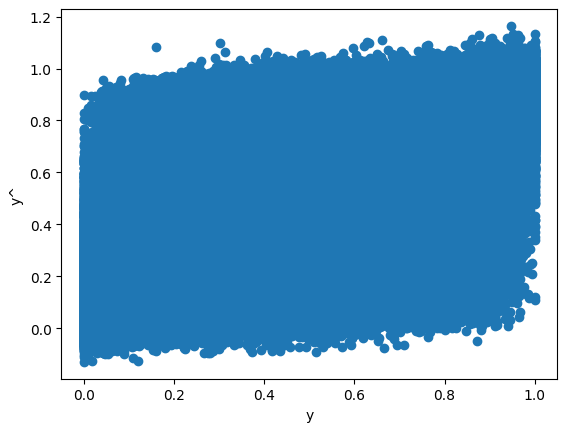


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941914916008768
RMSE 0.09456169899070536
MAE: 0.059392345651216094
R^2:  0.8710450641222052



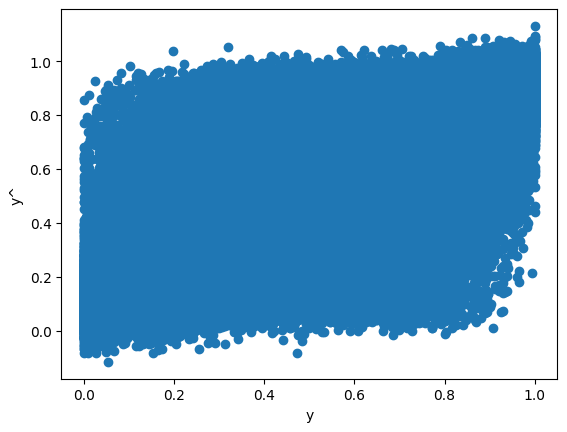


Testing time: 0.019 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933427355911548
RMSE 0.11803993966413041
MAE: 0.07891786160971462
R^2:  0.8094868093025294



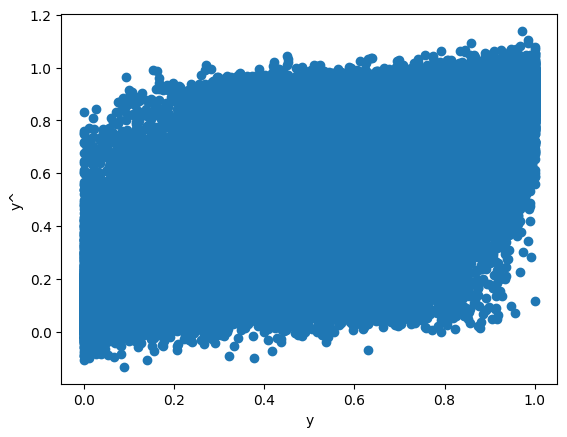

{'train': mse_t     0.012905
 rmse_t      0.1136
 mae_t     0.074545
 r2_t      0.823742
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059392
 r2_t      0.871045
 mse_v     0.013933
 rmse_v     0.11804
 mae_v     0.078918
 r2_v      0.809487
 dtype: object}

In [218]:
test_model_train_val_test(
    model, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

In [219]:
yhat = lin_reg.predict(X_sample_prepared)

In [220]:
yhat.shape

(54999,)

In [221]:
sample_data['percentage_docks_available'] = yhat

In [222]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')